# Computational Theory

## Introduction

This notebook implements key components of the SHA-256 cryptographic hash algorithm as specified in [FIPS 180-4](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.180-4.pdf). SHA-256 is widely used for data integrity verification, digital signatures, and password hashing. Through five problems, we will explore the bitwise operations, constant derivation, message padding, hash computation, and practical security implications of this algorithm.

## Table of Contents

1. [Problem 1: Binary Words and Operations](#Problem-1:-Binary-Words-and-Operations)
2. [Problem 2: Fractional Parts of Cube Roots](#Problem-2:-Fractional-Parts-of-Cube-Roots)
3. [Problem 3: Padding](#Problem-3:-Padding)
4. [Problem 4: Hashes](#Problem-4:-Hashes)
5. [Problem 5: Passwords](#Problem-5:-Passwords)
6. [Conclusion](#Conclusion)

In [101]:
import numpy as np
import hashlib
import string
import itertools
import matplotlib.pyplot as plt

## Problem 1: Binary Words and Operations

### Parity Function

The Parity Function is a symmetric boolean function , meaning the order of 1s does not change the output. The parity function is typically used to classify a function as either even , odd or neither. In this case we are using a bitwise XOR operation , XOR is a logical operator repesented by "^" in Python. It only returns true if both inputs differ from each other e. g : 1 ^ 1 = 0 , false even though there are two truths. 

This function returns the bitwise XOR of three 32-bit integers.
We will use the numpy.uint32 data type to ensure we meet the 32-bit word requirement for our SHA implementations,  SHA-256 , SHA-1 and SHA-224 all specifically require 32-bit words.


#### Formula
```
Parity(x, y, z) = x ⊕ y ⊕ z
```

#### Reference
[FIPS 180-4, Section 4.1.1](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.180-4.pdf)


In [61]:
def Parity(x, y, z):
    """Return the bitwise parity (XOR) of three 32-bit integers.
       Formula: Parity(x, y, z) = x ⊕ y ⊕ z"""
    
    # See : https://numpy.org/doc/stable/reference/arrays.scalars.html#numpy.int32

    # Convert all inputs to unsigned 32-bit integers
    x = np.uint32(x)
    y = np.uint32(y)
    z = np.uint32(z)

    # XOR all three together
    # The ^ operator in Python performs bitwise XOR
    return np.uint32(x ^ y ^ z)


### Ch Function

Ch stands for choose or choice, since the x input chooses if the output is from y or from z , the x acts as 
a selector.

- If `x` bit is `1` → **choose** the corresponding bit from `y`
- If `x` bit is `0` → **choose** the corresponding bit from `z`

#### Visual Example
```
If: x = 1100, y = 1010, z = 1001

| x | y | z | x=1? | Choose from | Result
|---|---|---|------|-------------|-------
| 1 | 1 | 1 | Yes  | y           | 1
| 1 | 0 | 0 | Yes  | y           | 0
| 0 | 1 | 0 | No   | z           | 0
| 0 | 0 | 1 | No   | z           | 1

Result: 1001
```

#### Formula
```
Ch(x, y, z) = (x ∧ y) ⊕ (¬x ∧ z)
```

- `(x ∧ y)` - Gets bits from `y` where `x = 1`
- `(¬x ∧ z)` - Gets bits from `z` where `x = 0` (after flipping x with NOT)
- `⊕` - Combines both parts (they don't overlap, so XOR merges them)

#### Reference
[FIPS 180-4, Section 4.1.1](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.180-4.pdf)

In [62]:
def Ch(x,y,z):
    """Returns the bitwise choice function result for three 32-bit integers.

       The Ch (Choose) function selects bits from y or z based on x:
       - If x bit is 1 → choose the corresponding bit from y
       - If x bit is 0 → choose the corresponding bit from z

       Formula: Ch(x, y, z) = (x ∧ y) ⊕ (¬x ∧ z)"""
    
    # Convert all inputs to unsigned 32-bit integers
    x = np.uint32(x)
    y = np.uint32(y)
    z = np.uint32(z)

    return np.uint32((x & y) ^ ((~x) & z))


### Maj Function

The Maj ( Majority) function implements a **majority vote** - it returns whichever bit value (0 or 1) appears most frequently among the three inputs at each position.

- If **2 or 3** inputs have bit `1` → output is `1`
- If **2 or 3** inputs have bit `0` → output is `0`

#### Visual Example
```
If: x = 1100, y = 1010, z = 1001

| x | y | z | Count of 1s | Majority | Result
|---|---|---|-------------|----------|-------
| 1 | 1 | 1 | 3           | 1        | 1
| 1 | 0 | 0 | 1           | 0        | 0
| 0 | 1 | 0 | 1           | 0        | 0
| 0 | 0 | 1 | 1           | 0        | 0

Result: 1000 
```

#### Formula
```
Maj(x, y, z) = (x ∧ y) ⊕ (x ∧ z) ⊕ (y ∧ z)
```

#### Reference
[FIPS 180-4, Section 4.1.1](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.180-4.pdf)

In [63]:
def Maj(x,y,z):
    """Return the bitwise majority function result for three 32-bit integers.
       The Maj (Majority) function returns the majority bit for each position:
       - If 2 or 3 inputs have bit=1 → output bit is 1
       - If 2 or 3 inputs have bit=0 → output bit is 0
    
       Formula: Maj(x, y, z) = (x ∧ y) ⊕ (x ∧ z) ⊕ (y ∧ z)"""
    
    # Convert all inputs to unsigned 32-bit integers
    x = np.uint32(x)
    y = np.uint32(y)
    z = np.uint32(z)
    
    return np.uint32((x & y) ^ (x & z) ^ (y & z))

### ROTR (Rotate Right) and SHR (Shift Right)

These are fundamental bit manipulation operations used in SHA-256 and SHA-224 functions. Understanding the difference between **rotation** (with wrap-around) and **shift** (without wrap-around) is important since they're both frequently used in section 4.1.2 and 4.1.3 of the FIPS PUB 180-4 . 

#### ROTR - Rotate Right (with wrap-around)

Bits that fall off the right edge **wrap back around** to the left side. This is very  important for preventing
the loss of any bits , only positional changes. ROTR is used in uppercase Sigma functions (Σ₀, Σ₁)

#### SHR - Shift Right (without wrap-around)

Bits that fall off the right edge are **lost forever**. Zeros fill in from the left and information is lost.
SHR doesn't necessarily require a function and can be used by simply writing ">>" in python. SHR is used in in lowercase sigma functions (σ₀, σ₁). 

Originally, I was mistaken in manually writing ">>" for my ROTR in all my Sigma functions but after revisiting
the problem I thankfully fixed what would've been a huge error.

#### Reference
[FIPS 180-4, Section 2.2.2, Symbols and Operations](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.180-4.pdf)

In [64]:
def ROTR(x , n):
    """Rotate right - bits wrap back around on the left"""
    x = np.uint32(x)
    return np.uint32((x >> n) | (x << (32 - n)))



def SHR(x, n):
    """SHR means regular shift (>>) with NO wrap-around.
       Bits that fall off are lost, zeros fill in from the left."""
    x = np.uint32(x)
    return np.uint32(x >> n)

In [65]:
def Sigma0(x):
    """Return the Sigma0 function used in SHA-256 for a 32-bit integer.
       This function uses THREE rotations (all bits wrap around):
       Formula: Σ₀(x) = ROTR²(x) ⊕ ROTR¹³(x) ⊕ ROTR²²(x)
       
       - No regular shifts (SHR) are used in uppercase Sigma functions"""
    
    # Ensure unsigned 32-bit requirement
    x = np.uint32(x)

    # Three rotations (all bits wrap around)
    rotr2 = ROTR(x, 2)
    rotr13 = ROTR(x, 13)
    rotr22 = ROTR(x, 22)

    # XOR all three together
    result = rotr2 ^ rotr13 ^ rotr22

    return np.uint32(result)



### Sigma Functions (Σ and σ)

The Sigma functions are **bit mixing operations** that combine multiple rotation algorithms (and sometimes shifts) using XOR. SHA-256 and SHA-224 uses four different Sigma functions, distinguished by case (uppercase vs lowercase).

#### Uppercase Sigma (Σ) - Only Rotations

**Σ₀ (Sigma0) and Σ₁ (Sigma1)** use **three rotations only** - no regular shifts.
```
Σ₀(x) = ROTR²(x) ⊕ ROTR¹³(x) ⊕ ROTR²²(x)
Σ₁(x) = ROTR⁶(x) ⊕ ROTR¹¹(x) ⊕ ROTR²⁵(x)
```

- All bits are preserved (rotation doesn't lose information)
- Creates complex mixing patterns by XORing different rotations
- Used in the **main compression function** of SHA-256

#### Lowercase sigma (σ) - Mix of Rotations and Shifts

**σ₀ (sigma0) and σ₁ (sigma1)** use **two rotations + one shift**.
```
σ₀(x) = ROTR⁷(x) ⊕ ROTR¹⁸(x) ⊕ SHR³(x)
σ₁(x) = ROTR¹⁷(x) ⊕ ROTR¹⁹(x) ⊕ SHR¹⁰(x)
```

- Combines reversible (ROTR) and irreversible (SHR) operations
- The shift operation **destroys information**, adding non-linearity
- Used in the **message schedule** (expanding the input message)

#### Reference
[FIPS 180-4, Section 4.1.2, SHA-224 and SHA-256 Functions](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.180-4.pdf)


In [66]:
def Sigma1(x):
    """Return the Sigma1 function used in SHA-256 for a 32-bit integer.
       This function uses THREE rotations (all bits wrap around):
       Formula: Σ₁(x) = ROTR⁶(x) ⊕ ROTR¹¹(x) ⊕ ROTR²⁵(x)
       
       - No regular shifts (SHR) are used in uppercase Sigma functions"""
    
    # Ensure unsigned 32-bit requirement
    x = np.uint32(x)

    # Three rotations (all bits wrap around)
    rotr6 = ROTR(x, 6)
    rotr11 = ROTR(x, 11)
    rotr25 = ROTR(x, 25)

     # XOR all three together
    result = rotr6 ^ rotr11 ^ rotr25

    return np.uint32(result)


In [67]:
def sigma0(x):
    """Return the sigma0 function used in SHA-256 for a 32-bit integer.
       This function uses TWO rotations and ONE shift:
       Formula: σ₀(x) = ROTR⁷(x) ⊕ ROTR¹⁸(x) ⊕ SHR³(x)"""
    
    # Ensure unsigned 32-bit requirement
    x = np.uint32(x)

    # Two rotations (bits wrap around)
    rotr7 = ROTR(x, 7)
    rotr18 = ROTR(x, 18)

    # One regular shift (bits are lost - NO wrap around)
    shr3 = SHR(x,3) # Or simply x >> 3

    # XOR all three together
    result = rotr7 ^ rotr18 ^ shr3

    return np.uint32(result)


In [68]:
def sigma1(x):
    """Return the sigma1 function used in SHA-256 for a 32-bit integer.
       This function uses TWO rotations and ONE shift:
       Formula: σ₁(x) = ROTR¹⁷(x) ⊕ ROTR¹⁹(x) ⊕ SHR¹⁰(x)"""
    
    # Ensure unsigned 32-bit requirement
    x = np.uint32(x)

    # Two rotations (bits wrap around)
    rotr17 = ROTR(x, 17)
    rotr19 = ROTR(x, 19)

    # One regular shift (bits are lost - NO wrap around)
    shr10 = SHR(x,10) # Or simply x >> 10

    # XOR all three together
    result = rotr17 ^ rotr19 ^ shr10

    return np.uint32(result)


### Testing Problem 1 Functions

#### Testing Parity

The Parity function performs XOR on three inputs. We'll verify with:
- x = 0b1100 (12 in decimal)
- y = 0b1010 (10 in decimal)  
- z = 0b1001 (9 in decimal)

The XOR operation works step by step:

**Step 1: x ⊕ y**
```
   1100
⊕ 1010
------
   0110 (6 in decimal)
```

**Step 2: (x ⊕ y) ⊕ z**
```
   0110
⊕ 1001
------
   1111 (15 in decimal)
```



In [69]:
# Test Parity function
print("--- Testing Parity ---")
x, y, z = 0b1100, 0b1010, 0b1001

# Show inputs
print(f"x = {x:04b} ({x})")
print(f"y = {y:04b} ({y})")
print(f"z = {z:04b} ({z})")

# Calculate result
result = Parity(x, y, z)
print(f"\nParity(x, y, z) = {result:04b} ({result})")

# Verify
expected = 15
assert result == expected, f"Test failed, expected {expected}, got {result}"
print(f"Test passed , result matches expected value of {expected}\n")

--- Testing Parity ---
x = 1100 (12)
y = 1010 (10)
z = 1001 (9)

Parity(x, y, z) = 1111 (15)
Test passed , result matches expected value of 15



#### Testing Ch (Choose)

The Ch function chooses bits from y or z based on x:
- If x bit = 1 → choose from y
- If x bit = 0 → choose from z

We'll use the same inputs as before(x=1100, y=1010, z=1001)
Expected result: 1001 (9 in decimal)

In [70]:
# Test Ch function
print("--- Testing Ch (Choose) ---")
x, y, z = 0b1100, 0b1010, 0b1001

# Show inputs
print(f"x = {x:04b} ({x}) - selector")
print(f"y = {y:04b} ({y}) - first option")
print(f"z = {z:04b} ({z}) - second option")

# Calculate result
result = Ch(x, y, z)
print(f"\nCh(x, y, z) = {result:04b} ({result})")


# Verify
expected = 9
assert result == expected, f"Test failed: expected {expected}, got {result}"
print(f"\nTest passed, the result matches expected value of {expected}\n")

--- Testing Ch (Choose) ---
x = 1100 (12) - selector
y = 1010 (10) - first option
z = 1001 (9) - second option

Ch(x, y, z) = 1001 (9)

Test passed, the result matches expected value of 9



#### Testing Maj (Majority)

The Maj function returns the majority bit at each position.

Using the same inputs (x=1100, y=1010, z=1001)
Expected result: 1000 (8 in decimal)

In [71]:
# Test Maj function
print("-- Testing Maj (Majority) ---")
x, y, z = 0b1100, 0b1010, 0b1001

# Show inputs
print(f"x = {x:04b} ({x})")
print(f"y = {y:04b} ({y})")
print(f"z = {z:04b} ({z})")

# Calculate result
result = Maj(x, y, z)
print(f"\nMaj(x, y, z) = {result:04b} ({result})")


# Verify
expected = 8
assert result == expected, f"Test failed, expected {expected}, got {result}"
print(f"\nTest passed, result matches expected value of {expected}\n")

-- Testing Maj (Majority) ---
x = 1100 (12)
y = 1010 (10)
z = 1001 (9)

Maj(x, y, z) = 1000 (8)

Test passed, result matches expected value of 8



#### Testing Sigma Functions

The Sigma functions combine multiple rotations (and shifts for lowercase sigma).
We'll verify they execute without errors and produce consistent results.


In [72]:
# Test ROTR with known value

print("--- Testing ROTR Function ---")

test_rotr = np.uint32(0x80000001)
expected_rotr = np.uint32(0xc0000000)
assert ROTR(test_rotr, 1) == expected_rotr, "ROTR test failed"
print(f"ROTR(0x80000001, 1) = 0x{ROTR(test_rotr, 1):08x} (expected 0xc0000000) - Test passed\n")


--- Testing ROTR Function ---
ROTR(0x80000001, 1) = 0xc0000000 (expected 0xc0000000) - Test passed



In [73]:
# Test all Sigma functions
print("--- Testing Sigma Functions ---")
test_value = 0b1100

print(f"Test value: {test_value:032b} ({test_value})\n")

# Test Sigma0
result_Sigma0 = Sigma0(test_value)
print(f"Sigma0({test_value}):  {result_Sigma0:032b} ({result_Sigma0})")

# Test Sigma1
result_Sigma1 = Sigma1(test_value)
print(f"Sigma1({test_value}):  {result_Sigma1:032b} ({result_Sigma1})")

# Test sigma0
result_sigma0 = sigma0(test_value)
print(f"sigma0({test_value}):  {result_sigma0:032b} ({result_sigma0})")

# Test sigma1
result_sigma1 = sigma1(test_value)
print(f"sigma1({test_value}):  {result_sigma1:032b} ({result_sigma1})")

print("\nAll Sigma functions executed.")

--- Testing Sigma Functions ---
Test value: 00000000000000000000000000001100 (12)

Sigma0(12):  00000000011000000011000000000011 (6303747)
Sigma1(12):  00110001100000000000011000000000 (830473728)
sigma0(12):  00011000000000110000000000000001 (402849793)
sigma1(12):  00000000000001111000000000000000 (491520)

All Sigma functions executed.


## Problem 2: Fractional Parts of Cube Roots

### Primes(n) Function

This function generates the first n **prime numbers**.

#### Prime Number:
```
A prime number by definition is a whole number greater than 1 that cannot be exactly divided by any whole number other than itself and 1 (e.g. 2 , 3 , 5 , 7 , 11).
 ```
 Key properties:
- 2 is the only even prime number
- All other primes are odd
- There are infinitely many prime numbers
- Primes have no divisibility patterns, making them unpredictable

 Prime numbers are very useful in cryptogaphy because they have no patterns.

 #### Three Implementations

I wrote three different and progressively optimized implementations:

1. **primes_manual(n)** - Basic algorithm for educational purposes, checks all divisors from 2 to n-1
2. **primes_manual_2(n)** - Optimized version using square root check and skipping even numbers
3. **primes(n)** - NumPy vectorized version for production use with best performance

In [74]:
def primes_manual(n):
    """Generate the first n prime numbers using a basic algorithm."""

    if n <= 0:
        return []
    
    primes = []  # List to store our prime numbers
    candidate = 2  # Starting with the first prime number


    while len(primes) < n:
        is_prime = True
        
        # Check if candidate is divisible by any number from 2 to candidate-1
        # If candidate = 5: range(2, 5) → [2, 3, 4]

        for divisor in range(2, candidate):
            if candidate % divisor == 0:
                # Found a divisor, so not prime
                is_prime = False
                break
        
        if is_prime:
            primes.append(candidate)
        
        candidate += 1
    
    return primes

In [75]:
def primes_manual_2(n):
    """
    This is an optimised version of the previous manual (no numpy)
    prime function , including two separate optimisations to make this 
    more efficient.

    This version only checks divisors up to the square root of the candidate,
    and skips even numbers after 2.
    """

    if n <= 0:
        return []
    
    primes = []
    candidate = 2
    
    while len(primes) < n:
        is_prime = True
        
        """
         If a number doesn't find a divisor before its square root , it is not a prime number. So , we'll only check up to the square root.
         To check in python you write " n ** 0.5 " which means the power of 0.5 which is the square root.
         Then we'll convert to an int so it's a whole number. To include the number in the range we write + 1.
        """
        for divisor in range(2, int(candidate ** 0.5) + 1):
            if candidate % divisor == 0:
                is_prime = False
                break
        
        if is_prime:
            primes.append(candidate)
        
        # Optimization: After 2, only check odd numbers
        if candidate == 2:
            candidate = 3
        else:
            candidate += 2  # Skip even numbers since 2 is the only even prime number.
    
    return primes

In [76]:
def primes(n):
    """
    Generate the first n prime numbers using NumPy for improved performance.
    
    This combines the manual approach with NumPy's speed for divisibility checks.
    """

    # see : https://numpy.org/doc/stable/reference/generated/numpy.array.html
    if n <= 0:
        return np.array([])
    
    primes = [2]  
    candidate = 3

    while len(primes) < n:
        # Convert current primes list to NumPy array
        primes_array = np.array(primes)
        
        # Only check primes up to sqrt(candidate)
        check_primes = primes_array[primes_array <= int(np.sqrt(candidate))]
        
        # Check if candidate is divisible by any existing prime
        if not np.any(candidate % check_primes == 0):
            primes.append(candidate)
        
        candidate += 2  # Only check odd numbers
    
    return np.array(primes)

### Cube Roots Function
This function calculates the cube root of the first **64 prime numbers**.

#### Calculating SHA-256 K Constants

SHA-256 uses 64 special constants (called K constants) in its hash computation algorithm. These constants are derived from the cube roots of the first 64 prime numbers, specifically the first 32 bits of their fractional parts.


#### What is a cube root

A cube root is the number that, when multiplied by itself three times, gives the original number:
```
∛8 = 2     because 2 × 2 × 2 = 8
∛27 = 3    because 3 × 3 × 3 = 27
```

For most numbers, cube roots are irrational (never-ending decimals):
```
∛2 = 1.25992104989487316...
∛3 = 1.44224957030740838...
∛5 = 1.70997594667669698...
```

#### Fractional Parts

Every decimal number has two parts:
- **Integer part**: The whole number before the decimal point
- **Fractional part**: Everything after the decimal point

Example with ∛2 = 1.25992104989487316:
```
Integer part:    1
Fractional part: 0.25992104989487316...
```

#### Extracting 32 Bits from the Fractional Part

This is what took me the longest to understand.
We need to convert the fractional decimal into binary and extract the first 32 bits.

The solution is to multiply by 2³² which equals 4,294,967,296.

This multiplication shifts the binary point 32 positions to the right. The first 32 fractional bits move from after the decimal point to before it. Once they're in the integer position, we can capture them using int().


Visual representation:

Example with prime = 2:
```
Cube root:        1.25992104989487316
Fractional part:  0.25992104989487316
Multiply by 2³²:  0.25992... × 4,294,967,296 = 1,116,352,408.185...
Integer part:     1,116,352,408
In hexadecimal:   428a2f98
```

#### Reference
[FIPS 180-4, Section 4.2.2 - SHA-224 and SHA-256 Constants](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.180-4.pdf)

In [77]:
def calculate_k_constants(n=64):
    """
    Calculate the K constants for SHA-256.
    
    These are the first 32 bits of the fractional parts of the 
    cube roots of the first n prime numbers.
    
    Number of constants to generate (default: 64 for SHA-256)
        
    """

    # Get the first n primes using primes() function
    prime_list = primes(n)
    
    # Initialize empty list to store constants
    constants = []
    
    # Process each prime number
    for i, prime in enumerate(prime_list):
        
       
        # np.cbrt() is more accurate than prime ** (1/3)
        # see : https://numpy.org/doc/stable/reference/generated/numpy.cbrt.html#numpy.cbrt
        cube_root = np.cbrt(prime)
        
        # Extract the fractional part
        # fractional_part = everything after the decimal point
        fractional_part = cube_root - int(cube_root)
        
        #  Get first 32 bits of the fractional part
        # Multiply by 2^32 to shift the binary point 32 positions right
        bits_32 = int(fractional_part * (2 ** 32))
        
        # Convert to hexadecimal (8 hex digits = 32 bits)
        # :08x means: pad to 8 characters, lowercase hex, removes the '0x' prefix
        hex_value = f"{bits_32:08x}"
        
        #  Add to our list of constants
        constants.append(hex_value)
    
    # Return all 64 constants
    return constants

### Testing Problem 2 Functions

### Testing Prime Generation Functions

Before using our prime functions for K constant generation, let's verify they work correctly and produce the same results.

In [78]:
# Test all three prime generation functions
print("=== Testing Prime Generation Functions ===\n")

# Test with small n first
n_test = 10
expected_10_primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

print(f"Testing with n = {n_test}")
print(f"Expected: {expected_10_primes}\n")

# Test 1: Basic Manual Version
print("1. primes_manual(10):")
primes_man = primes_manual(n_test)
print(f"   Result: {primes_man}")
assert primes_man == expected_10_primes, f"Basic manual failed!"
print("   Correct answer\n")

# Test 2: Optimized Manual Version
print("2. primes_manual_2(10):")
primes_opt = primes_manual_2(n_test)
print(f"   Result: {primes_opt}")
assert primes_opt == expected_10_primes, f"Optimized manual failed!"
print("   Correct answer\n")

# Test 3: NumPy Version
print("3. primes(10):")
primes_np = primes(n_test)
print(f"   Result: {primes_np}")
assert list(primes_np) == expected_10_primes, f"NumPy version failed!"
print("   Correct answer\n")

=== Testing Prime Generation Functions ===

Testing with n = 10
Expected: [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

1. primes_manual(10):
   Result: [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]
   Correct answer

2. primes_manual_2(10):
   Result: [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]
   Correct answer

3. primes(10):
   Result: [ 2  3  5  7 11 13 17 19 23 29]
   Correct answer



### Testing Cube Root ( k constants) Function

We'll compare the results from the calculate_k_constants function to a list of the official standard k constants
from :

[FIPS 180-4, Section 4.2.2 - SHA-224 and SHA-256 Constants](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.180-4.pdf)


In [79]:
# SHA-256 K constants from FIPS 180-4 (page 11)
# These are the official constants we should compare against
STANDARD_K_CONSTANTS = [
    '428a2f98', '71374491', 'b5c0fbcf', 'e9b5dba5', 
    '3956c25b', '59f111f1', '923f82a4', 'ab1c5ed5',
    'd807aa98', '12835b01', '243185be', '550c7dc3', 
    '72be5d74', '80deb1fe', '9bdc06a7', 'c19bf174',
    'e49b69c1', 'efbe4786', '0fc19dc6', '240ca1cc', 
    '2de92c6f', '4a7484aa', '5cb0a9dc', '76f988da',
    '983e5152', 'a831c66d', 'b00327c8', 'bf597fc7', 
    'c6e00bf3', 'd5a79147', '06ca6351', '14292967',
    '27b70a85', '2e1b2138', '4d2c6dfc', '53380d13', 
    '650a7354', '766a0abb', '81c2c92e', '92722c85',
    'a2bfe8a1', 'a81a664b', 'c24b8b70', 'c76c51a3', 
    'd192e819', 'd6990624', 'f40e3585', '106aa070',
    '19a4c116', '1e376c08', '2748774c', '34b0bcb5', 
    '391c0cb3', '4ed8aa4a', '5b9cca4f', '682e6ff3',
    '748f82ee', '78a5636f', '84c87814', '8cc70208', 
    '90befffa', 'a4506ceb', 'bef9a3f7', 'c67178f2'
]

# Calculate the 64 SHA-256 K constants
print("=== Calculating SHA-256 K Constants ===\n")
calculated_constants = calculate_k_constants(64)
print(f"Generated {len(calculated_constants)} constants\n")

# Print all 64 constants side-by-side for comparison
print("=== Comparing All 64 Constants ===")
print("Index | Calculated | Standard   | Match")
print("------|------------|------------|------")

all_match = True
for i in range(64):
    calc = calculated_constants[i]
    std = STANDARD_K_CONSTANTS[i]
    match = "       Yes" if calc == std else "       No"
    
    if calc != std:
        all_match = False
    
    print(f"K[{i:2d}] | {calc} | {std} | {match}")

print()


# Summary
if all_match:
    print("=" * 50)
    print("All 64 constants match perfectly!")
    print("=" * 50)
    print()
   
    
else:
    print("=" * 50)
    print(f"All 64 constants do not match")
    print("=" * 50)

=== Calculating SHA-256 K Constants ===

Generated 64 constants

=== Comparing All 64 Constants ===
Index | Calculated | Standard   | Match
------|------------|------------|------
K[ 0] | 428a2f98 | 428a2f98 |        Yes
K[ 1] | 71374491 | 71374491 |        Yes
K[ 2] | b5c0fbcf | b5c0fbcf |        Yes
K[ 3] | e9b5dba5 | e9b5dba5 |        Yes
K[ 4] | 3956c25b | 3956c25b |        Yes
K[ 5] | 59f111f1 | 59f111f1 |        Yes
K[ 6] | 923f82a4 | 923f82a4 |        Yes
K[ 7] | ab1c5ed5 | ab1c5ed5 |        Yes
K[ 8] | d807aa98 | d807aa98 |        Yes
K[ 9] | 12835b01 | 12835b01 |        Yes
K[10] | 243185be | 243185be |        Yes
K[11] | 550c7dc3 | 550c7dc3 |        Yes
K[12] | 72be5d74 | 72be5d74 |        Yes
K[13] | 80deb1fe | 80deb1fe |        Yes
K[14] | 9bdc06a7 | 9bdc06a7 |        Yes
K[15] | c19bf174 | c19bf174 |        Yes
K[16] | e49b69c1 | e49b69c1 |        Yes
K[17] | efbe4786 | efbe4786 |        Yes
K[18] | 0fc19dc6 | 0fc19dc6 |        Yes
K[19] | 240ca1cc | 240ca1cc |        Yes


## Problem 3: Padding

SHA-256 processes messages in fixed 512-bit blocks. Since messages can be any length, we need to add padding to make the total length a multiple of 512 bits.

### Understanding Message Padding

#### Reference
[FIPS 180-4, Section 5.1](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.180-4.pdf)

According to FIPS 180-4 Section 5.1:

"The purpose of this padding is to ensure that the padded message is a multiple of 512 or 1024
bits, depending on the algorithm. Padding can be inserted before hash computation begins on a
message, or at any other time during the hash computation prior to processing the block(s) that
will contain the padding."

"Suppose that the length of the message, M, is l bits. Append the bit '1' to the end of the message, followed by k zero bits, where k is the smallest, non-negative solution to the equation l + 1 + k ≡ 448 (mod 512). Then append the 64-bit block that is equal to the number l expressed using a binary representation."

#### The Padding Algorithm

Given a message M with length l bits, we:

1. **Append a single '1' bit** to the end of the message
2. **Append k zero bits**, where k is the smallest non-negative solution to: l + 1 + k ≡ 448 (mod 512)
3. **Append the original length** as a 64-bit big-endian integer ( this is where the original length is stored)

The result: The padded message length is always a multiple of 512 bits.

#### "abc" Example

**Message "abc" (24 bits)**
```
Original:  01100001 01100010 01100011 (24 bits)
Add '1':   01100001 01100010 01100011 1
Add zeros:  24(bits) + 1 + k ≡ 448 (mod 512) (423 zero bits to reach 448 bits total)
Add length: (64-bit value: 24 in binary)

Result: Exactly 512 bits (one complete block)
```


In [80]:
def block_parse(msg):
    # Parse a message into 512-bit (64-byte) blocks with SHA-256 padding.

    BLOCK_SIZE = 64  # 64 bytes = 512 bits
    
    # Calculate message length in bits
    msg_len_bits = len(msg) * 8

    # Yield complete 64-byte blocks from the message
    # (If message is 200 bytes, yield first 3 complete blocks)
    position = 0
    while position + BLOCK_SIZE <= len(msg):
        yield msg[position:position + BLOCK_SIZE]
        position += BLOCK_SIZE

    # Handle the final block(s) with padding
    # Get remaining bytes (less than 64 bytes)
    remaining = msg[position:]
    remaining_len = len(remaining)

    
    # Build the padding
    # Add 0x80 byte  (the '1' bit + seven '0' bits) 
    # Could also write bytes([128])
    padding = remaining + b'\x80'
    
    # Check if we need one or two blocks
    # We need room for: remaining + 0x80 + length (8 bytes)
    # If it fits in 64 bytes, use one block
    # Otherwise, use two blocks
    
    if len(padding) + 8 <= BLOCK_SIZE:
        # One block is enough
        # Add zeros to reach 56 bytes, then add 8-byte length
        zeros_needed = BLOCK_SIZE - len(padding) - 8
        padding = padding + (b'\x00' * zeros_needed)
        padding = padding + msg_len_bits.to_bytes(8, 'big')
        yield padding
    else:
        # Need two blocks
        # Block 1: Fill with zeros to complete 64 bytes
        zeros_needed = BLOCK_SIZE - len(padding)
        block1 = padding + (b'\x00' * zeros_needed)
        yield block1
        
        # Block 2: 56 zeros + 8-byte length
        block2 = (b'\x00' * 56) + msg_len_bits.to_bytes(8, 'big')
        yield block2


In [81]:
# Test with "abc"
print("\n=== TEST: 'abc' ===")

msg = b"abc"
blocks = list(block_parse(msg))

print(f"\nGenerated {len(blocks)} block(s)")
for i, block_words in enumerate(blocks):
    print(f"Block {i+1}: {len(block_words)} bytes")



=== TEST: 'abc' ===

Generated 1 block(s)
Block 1: 64 bytes


In [82]:
# Test empty message
print("\n=== TEST: Empty Message ===")
blocks_empty = list(block_parse(b""))
print(f"Empty message: {len(blocks_empty)} block(s)")
assert len(blocks_empty) == 1, "Empty message should produce 1 block"



=== TEST: Empty Message ===
Empty message: 1 block(s)


In [83]:
# Test 55-byte message (fits in one block)
print("\n=== TEST: 55-byte message ===")
blocks_55 = list(block_parse(b"a" * 55))
print(f"55-byte message: {len(blocks_55)} block(s)")
assert len(blocks_55) == 1, "55-byte message should produce 1 block"


=== TEST: 55-byte message ===
55-byte message: 1 block(s)


In [84]:
# Test 56-byte message (needs two blocks)
print("\n=== TEST: 56-byte message ===")
blocks_56 = list(block_parse(b"a" * 56))
print(f"56-byte message: {len(blocks_56)} block(s)")
assert len(blocks_56) == 2, "56-byte message should produce 2 blocks"


=== TEST: 56-byte message ===
56-byte message: 2 block(s)


## Problem 4: Hashes

The hash function is a core part of SHA-256. It takes a current hash value and a message block then produces the next hash value.

### Reference
[FIPS 180-4, Section 6.2.2 - SHA-256 Hash Computation](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.180-4.pdf)

Rogaway, P. & Shrimpton, T. (2004). [Cryptographic Hash-Function Basics](https://web.cs.ucdavis.edu/~rogaway/papers/relates.pdf) - Definitions and properties of cryptographic hash functions

### Overview

The hash function has four steps:

**Step 1: Prepare Message Schedule**
- Expand the 64-byte block into 64 words (W[0] to W[63])
- First 16 words come directly from the block
- Remaining 48 words calculated using: `W[t] = sigma1(W[t-2]) + W[t-7] + sigma0(W[t-15]) + W[t-16]`

**Step 2: Initialize Working Variables**
- Set eight variables (a, b, c, d, e, f, g, h) to the current hash values

**Step 3: Main Loop (64 rounds)**
- For each round t from 0 to 63:
  - Calculate T1 and T2 using the Ch, Maj, Sigma0, and Sigma1 functions
  - Rotate and update the working variables

**Step 4: Compute New Hash**
- Add the final working variables to the current hash
- Return the result as the new hash value

### Key Components

**Constants Used:**
- K constants from Problem 2 (64 values)
- Initial hash values from FIPS 180-4 Section 5.3.3

**Functions Used:**
- Ch, Maj, Sigma0, Sigma1 from Problem 1 (main loop)
- sigma0, sigma1 from Problem 1 (message schedule)


In [85]:
# SHA-256 K constants (from Problem 2)
K = np.array([0x428a2f98, 0x71374491, 0xb5c0fbcf, 0xe9b5dba5, 0x3956c25b, 0x59f111f1, 0x923f82a4, 0xab1c5ed5, 
0xd807aa98, 0x12835b01, 0x243185be, 0x550c7dc3, 0x72be5d74, 0x80deb1fe, 0x9bdc06a7, 0xc19bf174, 
0xe49b69c1, 0xefbe4786, 0x0fc19dc6, 0x240ca1cc, 0x2de92c6f, 0x4a7484aa, 0x5cb0a9dc, 0x76f988da, 
0x983e5152, 0xa831c66d, 0xb00327c8, 0xbf597fc7, 0xc6e00bf3, 0xd5a79147, 0x06ca6351, 0x14292967, 
0x27b70a85, 0x2e1b2138, 0x4d2c6dfc, 0x53380d13, 0x650a7354, 0x766a0abb, 0x81c2c92e, 0x92722c85, 
0xa2bfe8a1, 0xa81a664b, 0xc24b8b70, 0xc76c51a3, 0xd192e819, 0xd6990624, 0xf40e3585, 0x106aa070, 
0x19a4c116, 0x1e376c08, 0x2748774c, 0x34b0bcb5, 0x391c0cb3, 0x4ed8aa4a, 0x5b9cca4f, 0x682e6ff3, 
0x748f82ee, 0x78a5636f, 0x84c87814, 0x8cc70208, 0x90befffa, 0xa4506ceb, 0xbef9a3f7, 0xc67178f2, ], dtype=np.uint32)

# Initial hash value - Section 5.3.3.
INITIAL_HASH = np.array([
  0x6a09e667, 0xbb67ae85, 0x3c6ef372, 0xa54ff53a,
  0x510e527f, 0x9b05688c, 0x1f83d9ab, 0x5be0cd19,
], dtype=np.uint32)

In [86]:
def hash(current , block):
    """
    Compute next hash from current hash and message block.
    
    Parameters:  current : numpy array , Current hash value (8 32-bit words)
                 block : bytes ,64-byte message block
        
    Returns: numpy array , next hash value (8 32-bit words)
        
    Reference: FIPS 180-4, Section 6.2.2
    """
    
    # Convert the 64-byte block into 16 32-bit words
    block_words = np.frombuffer(block, dtype='>u4')

    # Verify there's 16 words
    if len(block_words) != 16:
        raise ValueError(f"Expected 16 words, got {len(block_words)}")
    
    # Create array for 64-element message schedule
    W = np.zeros(64, dtype=np.uint32)
    
    # First 16 elements come from the message block
    for t in range(16):
        W[t] = block_words[t]
    
    # Remaining 48 elements are calculated
    for t in range(16, 64):
        W[t] = sigma1(W[t-2]) + W[t-7] + sigma0(W[t-15]) + W[t-16]
    
    # Initialize working variables with current hash
    a = current[0]
    b = current[1]
    c = current[2]
    d = current[3]
    e = current[4]
    f = current[5]
    g = current[6]
    h = current[7]
    
    # Main loop - 64 rounds
    for t in range(64):
        T1 = h + Sigma1(e) + Ch(e, f, g) + K[t] + W[t]
        T2 = Sigma0(a) + Maj(a, b, c)
        h = g
        g = f
        f = e
        e = d + T1
        d = c
        c = b
        b = a
        a = T1 + T2
    
    # Compute new hash value
    H = np.array([
        a + current[0], b + current[1], c + current[2], d + current[3],
        e + current[4], f + current[5], g + current[6], h + current[7],
    ], dtype=np.uint32)
    
    return H

In [87]:
print("=== Testing hash() Function ===\n")

# Test with "abc"
msg = b"abc"
blocks = list(block_parse(msg))

print(f"Message: {msg}")
print(f"Number of blocks: {len(blocks)}")
print()

# DEBUG: Check what's in the block
#print("DEBUG: Block details:")
#print(f"  Block type: {type(blocks[0])}")
#print(f"  Block length: {len(blocks[0])} bytes")
#print()

# Start with initial hash
current_hash = INITIAL_HASH.copy()
print("Initial hash:")
print(' '.join([f'{h:08x}' for h in current_hash]))
print()

# Process the block
next_hash = hash(current_hash, blocks[0])
print("Hash after processing block:")
our_result = ''.join([f'{h:08x}' for h in next_hash])
print(our_result)
print()

# Compare with Python's hashlib
expected = hashlib.sha256(b"abc").hexdigest()

print("Verification:")
print(f"  Expected (hashlib): {expected}")
print(f"  Our result:         {our_result}")
print()

if our_result == expected:
    print("SUCCESS - Hash matches")
else:
    print("Hashes don't match")

print("\n" + "="*50 + "\n")


=== Testing hash() Function ===

Message: b'abc'
Number of blocks: 1

Initial hash:
6a09e667 bb67ae85 3c6ef372 a54ff53a 510e527f 9b05688c 1f83d9ab 5be0cd19

Hash after processing block:
ba7816bf8f01cfea414140de5dae2223b00361a396177a9cb410ff61f20015ad

Verification:
  Expected (hashlib): ba7816bf8f01cfea414140de5dae2223b00361a396177a9cb410ff61f20015ad
  Our result:         ba7816bf8f01cfea414140de5dae2223b00361a396177a9cb410ff61f20015ad

SUCCESS - Hash matches




/tmp/ipykernel_1677/4067166065.py:29: RuntimeWarning: overflow encountered in scalar add
  W[t] = sigma1(W[t-2]) + W[t-7] + sigma0(W[t-15]) + W[t-16]
/tmp/ipykernel_1677/4067166065.py:43: RuntimeWarning: overflow encountered in scalar add
  T1 = h + Sigma1(e) + Ch(e, f, g) + K[t] + W[t]
/tmp/ipykernel_1677/4067166065.py:44: RuntimeWarning: overflow encountered in scalar add
  T2 = Sigma0(a) + Maj(a, b, c)
/tmp/ipykernel_1677/4067166065.py:48: RuntimeWarning: overflow encountered in scalar add
  e = d + T1
/tmp/ipykernel_1677/4067166065.py:52: RuntimeWarning: overflow encountered in scalar add
  a = T1 + T2
/tmp/ipykernel_1677/4067166065.py:56: RuntimeWarning: overflow encountered in scalar add
  a + current[0], b + current[1], c + current[2], d + current[3],
/tmp/ipykernel_1677/4067166065.py:57: RuntimeWarning: overflow encountered in scalar add
  e + current[4], f + current[5], g + current[6], h + current[7],


In [88]:
print("=== Test 2: Empty Message ===\n")

# Test with empty message
msg = b""
blocks = list(block_parse(msg))

print(f"Message: (empty)")
print(f"Message length: {len(msg)} bytes")
print(f"Number of blocks: {len(blocks)}")
print()

# Start with initial hash
current_hash = INITIAL_HASH.copy()

# Process each block (should be just 1 for empty message)
for i, block in enumerate(blocks):
    print(f"Processing block {i+1}...")
    current_hash = hash(current_hash, block)

# Final result
our_result = ''.join([f'{h:08x}' for h in current_hash])
print(f"\nFinal hash: {our_result}")

# Compare with hashlib
expected = hashlib.sha256(b"").hexdigest()

print("\nVerification:")
print(f"  Expected (hashlib): {expected}")
print(f"  Our result:         {our_result}")
print()

if our_result == expected:
    print("SUCCESS - Empty message hash matches")
else:
    print("Hashes don't match")


=== Test 2: Empty Message ===

Message: (empty)
Message length: 0 bytes
Number of blocks: 1

Processing block 1...

Final hash: e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855

Verification:
  Expected (hashlib): e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855
  Our result:         e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855

SUCCESS - Empty message hash matches


/tmp/ipykernel_1677/4067166065.py:29: RuntimeWarning: overflow encountered in scalar add
  W[t] = sigma1(W[t-2]) + W[t-7] + sigma0(W[t-15]) + W[t-16]
/tmp/ipykernel_1677/4067166065.py:43: RuntimeWarning: overflow encountered in scalar add
  T1 = h + Sigma1(e) + Ch(e, f, g) + K[t] + W[t]
/tmp/ipykernel_1677/4067166065.py:44: RuntimeWarning: overflow encountered in scalar add
  T2 = Sigma0(a) + Maj(a, b, c)
/tmp/ipykernel_1677/4067166065.py:48: RuntimeWarning: overflow encountered in scalar add
  e = d + T1
/tmp/ipykernel_1677/4067166065.py:52: RuntimeWarning: overflow encountered in scalar add
  a = T1 + T2
/tmp/ipykernel_1677/4067166065.py:56: RuntimeWarning: overflow encountered in scalar add
  a + current[0], b + current[1], c + current[2], d + current[3],
/tmp/ipykernel_1677/4067166065.py:57: RuntimeWarning: overflow encountered in scalar add
  e + current[4], f + current[5], g + current[6], h + current[7],


## Problem 5: Passwords

For problem 5 we were given three SHA-256 hashes of common passwords. The passwords were encoded using UTF-8 and hashed with a single pass of SHA-256. The goal here is to:

1. Find the original passwords
2. Explain the method used to crack them
3. Suggest security improvements to prevent the attacks

### Overview

Password cracking demonstrates the vulnerabilities of weak password hashing practices. This problem explores dictionary attacks, brute force methods, and password patterns while highlighting why proper password security requires salting, key stretching, and password-specific hash functions.

### Target Hashes

1. `5e884898da28047151d0e56f8dc6292773603d0d6aabbdd62a11ef721d1542d8`
2. `873ac9ffea4dd04fa719e8920cd6938f0c23cd678af330939cff53c3d2855f34`
3. `b03ddf3ca2e714a6548e7495e2a03f5e824eaac9837cd7f159c67b90fb4b7342`

### Reference
- [FIPS 180-4 - Secure Hash Standard](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.180-4.pdf)
- [NIST SP 800-63B - Digital Identity Guidelines](https://pages.nist.gov/800-63-3/sp800-63b.html)

### Approach: Multi-Stage Attack Strategy

I used a five-stage approach to crack the passwords, progressing from basic to more complex methods.

### Stage 1: Dictionary Attack with Common Passwords

**Approach:** Test a curated list of frequently-used passwords from security breach databases.

**How it works:**
1. Take each password from the dictionary
2. Hash it using SHA-256
3. Compare the hash to our three targets
4. Record any matches

**Advantages:**
- Extremely fast (tests thousands per second)
- Catches the most common passwords immediately
- Minimal computational resources required

**Results from Stage 1:**
[1 found - password]

### Stage 2: Extended Dictionary Attack

**Approach:** Expand the dictionary with additional password variations and less common choices.

**Expanded sources included:**
- Names (michael, jessica, thomas)
- Sports teams (liverpool, manutd)
- Common words (freedom, cookie, summer)
- Simple variations (password1, passw0rd)

**Results from Stage 2:**
Found "cheese" (note: "password" was already found in Stage 1)

### Stage 3: Brute Force Attack

**Approach:** Systematically test all possible combinations within certain parameters using brute force.

**Parameters:**
- Character set: lowercase letters (a-z) + digits (0-9) = 36 characters
- Length range: 4 to 6 characters
- Method: Exhaustive search through all combinations

**Why these parameters:**
- Length 4-6 covers common password lengths , the longer the length the longer it will take
- Including digits catches passwords like "pass1", "hello123"
- 36-character charset balances coverage with computational feasibility

**Computational complexity:**
- Length 4: 36^4 = 1,679,616 combinations
- Length 5: 36^5 = 60,466,176 combinations  
- Length 6: 36^6 = 2,176,782,336 combinations

**Performance optimization:**
- Used Python's built-in hashlib library (written in C)
- ~100x faster than the first brute force python implementation
- Progress indicators every 100,000 passwords tested

**Results from Stage 3:**
Found "cheese" (note: "cheese" was already found in Stage 2)

### Stage 4: Password Variations & L33tspeak Patterns

**Approach:** Test common character substitution patterns that users employ to "strengthen" passwords.

**L33tspeak Explained:**
L33tspeak (from "1337" meaning "elite") is internet slang where letters are replaced with similar-looking numbers or symbols. Common substitutions include:
- a → @, 4
- e → 3
- i → 1, !
- o → 0
- s → $, 5

**Passwords tested:**
- Capitalization variations (Password, PASSWORD)
- L33tspeak substitutions (P@ssword, P@ssw0rd, pa$$w0rd)
- Number suffixes (password1, password123)
- Combined patterns (P@$$w0rd, Passw0rd!)

**Why this stage is important:**
Many users believe character substitutions make passwords secure. However, these patterns are well-documented and included in modern password cracking dictionaries. "P@ssw0rd" is fundamentally just "password" with cosmetic changes.

**Results from Stage 4:**
Found "P@ssw0rd" - demonstrating that l33tspeak provides minimal actual security.

### Stage 5: Rainbow Table Lookup (Not Needed)**

**What are rainbow tables:**
Rainbow tables are massive pre-computed databases of password hashes. Services like CrackStation.net contain 15+ billion password hashes, allowing instant lookup instead of real-time computation.

**Why I didn't use it:**
All three passwords were found using dictionary attacks and brute force. However, if "P@ssw0rd" hadn't been found in Stage 4, it would have been instantly found via rainbow table lookup.

**Defense against rainbow tables:**
Salting makes rainbow tables completely ineffective. With unique salts per user, the same password produces different hashes, making pre-computation impossible.

### Results Summary

**All three passwords were successfully cracked**

| Hash # | Password | Method Found | Time |
|--------|----------|--------------|------|
| 1 | password | Dictionary Attack (Stage 1) | < 1 second |
| 2 | cheese | Extended Dictionary (Stage 2) & Brute Force (Stage 3) | ~45 minutes |
| 3 | P@ssw0rd | Password Variations (Stage 4) | < 1 second |

**Total passwords tested in brute force:** 2,240,928,128 combinations  
**Total analysis time:** Approximately 45 minutes

### Security Improvements

### 1. Implement Salting

**What is salting:**
A salt is random data added to each password before hashing.

**Example:**
```
User 1: password → hash("random123" + "password")
User 2: password → hash("random456" + "password")
```

**Benefits:**
- Same password produces different hashes for different users
- Each password must be cracked individually

**Implementation:**
- Generate unique random salt per user (16+ bytes)
- Store salt alongside the hash (doesn't need to be secret)
- Combine salt + password before hashing

### 2. Enforce Strong Password Policies

**Add Minimum requirements:**
- Length: At least 12 characters (longer is better)
- Complexity: Mix of letters, numbers, symbols
- Check against breach databases
- Reject common passwords and patterns

**User-friendly approaches:**
- Use password managers to generate/store complex passwords
- Implement multi-factor authentication (MFA)

### 3. Use Key Stretching (Multiple Iterations)

**Concept:** Hash the password multiple times instead of once.

**Example:**
```
hash1 = SHA256(password)
hash2 = SHA256(hash1)
hash3 = SHA256(hash2)
... (repeat 10,000+ times)
```

**Benefits:**
- Multiplies the time needed to test each password
- 10,000 iterations = 10,000x slower for attackers
- Negligible impact on legitimate login (milliseconds)
- Major impact on brute force (years instead of hours)

**Modern standard:**
- PBKDF2: 100,000+ iterations recommended (https://en.wikipedia.org/wiki/PBKDF2)


### 4. Use Password-Specific Hash Functions

**Problem:** SHA-256 is too fast for passwords.

**Solution:** Use algorithms designed for password hashing:
- **bcrypt** - Automatically includes salt, adjustable work factor
- **scrypt** - Memory-hard function, resistant to GPU attacks
- **Argon2** - Modern, winner of Password Hashing Competition (2015)
- **PDBKDF2** - A NIST-recommended standard

**Why it helps:**
- These algorithms are intentionally slow (adjustable)
- Slows attackers from billions/second to thousands/second
- Includes built-in salting mechanisms

### Password List References

The common password lists used for dictionary attacks come from:

- **SecLists Project** - Curated password lists for security testing ([GitHub](https://github.com/danielmiessler/SecLists))
- **RockYou Breach (2009)** - 32 million passwords from security breach
- **SplashData Annual Reports** - "Worst Passwords" lists compiled from breaches
- **NIST SP 800-63B** - Recommends checking against known breached passwords

For this analysis, we test against a small set of the most common passwords documented in security research.

### Password Cracking Functions

In [89]:

def sha256(msg):
    """
    Compute the SHA-256 hash of a message.
    
    Parameters
    -----------
    msg : bytes
        The message to hash
        
    Returns
    -------
    str
        The hexadecimal hash digest (64 characters)
    """
    
    # Start with initial hash value
    current_hash = INITIAL_HASH.copy()
    
    # Process each block
    for block in block_parse(msg):
        current_hash = hash(current_hash, block)
    
    # Convert final hash to hexadecimal string
    return ''.join([f'{h:08x}' for h in current_hash])


In [90]:
def crack_with_dictionary(target_hashes, password_list):
    """
    Attempt to crack hashes using a dictionary attack.
    
    Parameters
    -----------
    target_hashes : list
        List of SHA-256 hashes to crack
    password_list : list
        List of passwords to test
        
    Returns
    -------
    dict
        Dictionary mapping hash index to (password, hash) tuple
    """
    found = {}
    
    for password in password_list:
        # Hash the password
        password_hash = sha256(password.encode('utf-8'))
        
        # Check against all target hashes
        for i, target in enumerate(target_hashes):
            if password_hash == target and i not in found:
                found[i] = (password, password_hash)
                print(f"Found Hash #{i+1}: '{password}'")
                print(f"   Hash: {password_hash}\n")
    
    return found



In [91]:
def crack_with_brute_force(target_hashes, charset=string.ascii_lowercase, max_length=4, min_length=1):
    """
    Attempt to crack hashes using brute-force attack.
    
    Parameters
    -----------
    target_hashes : list of str
        List of SHA-256 hashes to crack
    charset : str
        Characters to use (default: lowercase letters)
    max_length : int
        Maximum password length to try (default: 4) because 5 would take over 2 hours
    min_length : int
        Minimum password length to try (default: 1)
    
    Returns
    -------
    dict
        Mapping of hash index to (password, hash) tuple
    """
    found = {}
    
    for length in range(min_length, max_length + 1):
        print(f"Testing length {length}... ({len(charset)**length:,} combinations)")
        
        for combo in itertools.product(charset, repeat=length):
            password = ''.join(combo)
            password_hash = sha256(password.encode('utf-8'))
            
            for i, target in enumerate(target_hashes):
                if password_hash == target and i not in found:
                    found[i] = (password, password_hash)
                    print(f"Found Hash #{i+1}: '{password}' (length {length})")
                    print(f"   Hash: {password_hash}\n")
            
            if len(found) == len(target_hashes):
                print(f"All hashes found! Stopping now ...")
                return found
    
    return found



In [92]:
def crack_with_brute_force_fast(target_hashes, charset=string.ascii_lowercase, max_length=5, min_length=1):
    """
    Attempt to crack hashes using brute-force attack with hashlib (a faster version).
    
    Parameters
    -----------
    target_hashes : list of str
        List of SHA-256 hashes to crack
    charset : str
        Characters to use (default: lowercase letters)
    max_length : int
        Maximum password length to try (default: 5)
    min_length : int
        Minimum password length to try (default: 1)
    
    Returns
    -------
    dict
        Mapping of hash index to (password, hash) tuple
    """
    
    found = {}
    
    for length in range(min_length, max_length + 1):
        print(f"Testing length {length}... ({len(charset)**length:,} combinations)")
        
        tested = 0
        for combo in itertools.product(charset, repeat=length):
            password = ''.join(combo)
            
            # By using hashlib for speed this should be much faster than the previous implementation
            password_hash = hashlib.sha256(password.encode('utf-8')).hexdigest()
            
            tested += 1
            
            # Progress indicator every 100k passwords
            if tested % 100000 == 0:
                print(f"  Tested {tested:,} passwords...")
            
            for i, target in enumerate(target_hashes):
                if password_hash == target and i not in found:
                    found[i] = (password, password_hash)
                    print(f"Found Hash #{i+1}: '{password}' (length {length})")
                    print(f"   Hash: {password_hash}\n")
            
            if len(found) == len(target_hashes):
                print(f"All hashes found! Stopping early.")
                return found
        
        print(f"  Completed length {length}: {tested:,} passwords tested\n")
    
    return found


### Target Passwords & Common Password Lists

In [93]:
# The three password hashes we need to crack
target_hashes = [
    '5e884898da28047151d0e56f8dc6292773603d0d6aabbdd62a11ef721d1542d8',
    '873ac9ffea4dd04fa719e8920cd6938f0c23cd678af330939cff53c3d2855f34',
    'b03ddf3ca2e714a6548e7495e2a03f5e824eaac9837cd7f159c67b90fb4b7342',
]


# Common passwords based on security breach analysis
# Sources: RockYou breach, SplashData reports, NIST recommendations
# Reference: https://github.com/danielmiessler/SecLists

# Common passwords - small list for first attempt
common_passwords_small = [
    'password', '123456', '12345678', 'qwerty', 'abc123', 
    'monkey', '1234567', 'letmein', 'trustno1', 'dragon',
    'baseball', 'iloveyou', 'master', 'sunshine', 'ashley',
    'bailey', 'shadow', '123123', '654321', 'superman',
    'qazwsx', 'michael', 'football', 'password1', '000000',
]

# Expanded password list for second attempt
common_passwords_expanded = [
    'password', '123456', '12345678', 'qwerty', 'abc123', 
    'monkey', '1234567', 'letmein', 'trustno1', 'dragon',
    'baseball', 'iloveyou', 'master', 'sunshine', 'ashley',
    'bailey', 'shadow', '123123', '654321', 'superman',
    'qazwsx', 'michael', 'football', 'password1', '000000',
    'hello', 'charlie', 'aa123456', 'donald', 'password123',
    'hello123', 'welcome', 'admin', 'root', 'pass',
    'princess', 'starwars', 'whatever', 'passw0rd',
    'ninja', 'abc12345', 'mustang', 'solo',
    'access', 'loveme', 'buster', 'batman', 'tigger',
    'jordan', 'thomas', 'hockey', 'ranger', 'robert',
    'daniel', 'andrew', 'michelle', 'jessica', 'pepper',
    'liverpool', 'london', 'maggie', 'computer',
    'killer', 'dallas', 'zxcvbnm', 'cookie',
    'freedom', 'summer', 'flower', 'ginger', 'matrix',
    'secret', 'orange', 'biteme',
    'scooter', 'maverick', 'manutd',
    'cheese', 'soccer', 'purple', 'google', 'peanut',
    'ferrari', 'slipknot', 'twitter', 'money', 'mercedes',
]

# Common l33tspeak and variation patterns
password_variations = [
        # Direct variations of "password"
        'Password', 'PASSWORD', 'PassWord', 
        'password1', 'password123', 'password12',
        'P@ssword', 'P@ssw0rd', 'P@$$w0rd', 'P@ssw0rd!',
        'passw0rd', 'pa$$word', 'pa$$w0rd',
        
        # Other common patterns
        'Welcome1', 'Welcome123', 'W3lcome',
        'Admin123', '@dmin', '@dmin123',
        'Qwerty123', 'Qw3rty', 'qw3rty',
        'Monkey1', 'M0nkey', 
        'Dragon1', 'Dr@gon',
        'Football1', 'F00tball',
        'Baseball1', 'B@seball',
        'Master1', 'M@ster',
        'Letmein1', 'L3tmein',
        'Trustno1', 'Trust_no1',
        'Sunshine1', '$unshine',
        
        # Cheese variations (since we found this one)
        'Cheese', 'CHEESE', 'Cheese1', 'Ch33se',
        
        # Number patterns
        'abc123', 'Abc123', '@bc123',
        '123456', '12345678', '123456789',
        '654321', 'qwerty', 'Qwerty',
    ]

# Masterlist to track found passwords
found_passwords = []  # List to track all found passwords across attempts
results = {}  # Dictionary to store results


### Testing and Execution

In [94]:
print("=== Testing SHA-256 Function using test cases ===\n")

# Test cases
test_cases = [
    (b"", "e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855"),
    (b"abc", "ba7816bf8f01cfea414140de5dae2223b00361a396177a9cb410ff61f20015ad"),
    (b"Hello, World!", "dffd6021bb2bd5b0af676290809ec3a53191dd81c7f70a4b28688a362182986f"),
]

all_pass = True
for msg, expected in test_cases:
    our_result = sha256(msg)
    hashlib_result = hashlib.sha256(msg).hexdigest()
    
    match = our_result == expected == hashlib_result
    status = "Correct" if match else "Incorrect"
    
    print(f"Message: {msg}")
    print(f"  Expected: {expected}")
    print(f"  Got:      {our_result}")
    print(f"  {status}\n")
    
    if not match:
        all_pass = False

if all_pass:
    print("="*50)
    print("All tests passed! SHA-256 implementation ready! ")
    print("="*50)

# Masterlist to track found passwords
found_passwords = []  # List to track all found passwords across attempts
results = {}  # Dictionary to store results



=== Testing SHA-256 Function using test cases ===

Message: b''
  Expected: e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855
  Got:      e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855
  Correct

Message: b'abc'
  Expected: ba7816bf8f01cfea414140de5dae2223b00361a396177a9cb410ff61f20015ad
  Got:      ba7816bf8f01cfea414140de5dae2223b00361a396177a9cb410ff61f20015ad
  Correct

Message: b'Hello, World!'
  Expected: dffd6021bb2bd5b0af676290809ec3a53191dd81c7f70a4b28688a362182986f
  Got:      dffd6021bb2bd5b0af676290809ec3a53191dd81c7f70a4b28688a362182986f
  Correct

All tests passed! SHA-256 implementation ready! 


/tmp/ipykernel_1677/4067166065.py:29: RuntimeWarning: overflow encountered in scalar add
  W[t] = sigma1(W[t-2]) + W[t-7] + sigma0(W[t-15]) + W[t-16]
/tmp/ipykernel_1677/4067166065.py:43: RuntimeWarning: overflow encountered in scalar add
  T1 = h + Sigma1(e) + Ch(e, f, g) + K[t] + W[t]
/tmp/ipykernel_1677/4067166065.py:44: RuntimeWarning: overflow encountered in scalar add
  T2 = Sigma0(a) + Maj(a, b, c)
/tmp/ipykernel_1677/4067166065.py:48: RuntimeWarning: overflow encountered in scalar add
  e = d + T1
/tmp/ipykernel_1677/4067166065.py:52: RuntimeWarning: overflow encountered in scalar add
  a = T1 + T2
/tmp/ipykernel_1677/4067166065.py:56: RuntimeWarning: overflow encountered in scalar add
  a + current[0], b + current[1], c + current[2], d + current[3],
/tmp/ipykernel_1677/4067166065.py:57: RuntimeWarning: overflow encountered in scalar add
  e + current[4], f + current[5], g + current[6], h + current[7],


In [95]:
print("\n=== Attempt 1: Testing Common Passwords with sha256(msg) ===\n")
print(f"Testing {len(common_passwords_small)} common passwords from security breach databases\n")

results = {}

for password in common_passwords_small:
    # Hash the password
    password_hash = sha256(password.encode('utf-8'))
    
    # Check against all target hashes
    for i, target in enumerate(target_hashes):
        if password_hash == target and i not in results:
            results[i] = (password, password_hash)
            
            # Add to master list if not already there
            if password not in found_passwords:
                found_passwords.append(password)
            
            print(f"Found Hash #{i+1}: '{password}'")
            print(f"   Hash: {password_hash}\n")

print(f"Found {len(results)}/3 passwords in Attempt 1")
print(f"Master list: {found_passwords}")
print("="*50)




=== Attempt 1: Testing Common Passwords with sha256(msg) ===

Testing 25 common passwords from security breach databases

Found Hash #1: 'password'
   Hash: 5e884898da28047151d0e56f8dc6292773603d0d6aabbdd62a11ef721d1542d8



/tmp/ipykernel_1677/4067166065.py:29: RuntimeWarning: overflow encountered in scalar add
  W[t] = sigma1(W[t-2]) + W[t-7] + sigma0(W[t-15]) + W[t-16]
/tmp/ipykernel_1677/4067166065.py:43: RuntimeWarning: overflow encountered in scalar add
  T1 = h + Sigma1(e) + Ch(e, f, g) + K[t] + W[t]
/tmp/ipykernel_1677/4067166065.py:44: RuntimeWarning: overflow encountered in scalar add
  T2 = Sigma0(a) + Maj(a, b, c)
/tmp/ipykernel_1677/4067166065.py:48: RuntimeWarning: overflow encountered in scalar add
  e = d + T1
/tmp/ipykernel_1677/4067166065.py:52: RuntimeWarning: overflow encountered in scalar add
  a = T1 + T2
/tmp/ipykernel_1677/4067166065.py:56: RuntimeWarning: overflow encountered in scalar add
  a + current[0], b + current[1], c + current[2], d + current[3],
/tmp/ipykernel_1677/4067166065.py:57: RuntimeWarning: overflow encountered in scalar add
  e + current[4], f + current[5], g + current[6], h + current[7],


Found 1/3 passwords in Attempt 1
Master list: ['password']


In [96]:
# Attempt 2: If not all found, try dictionary attack using crack_with_dictionary() function with larger list

if len(results) < 3:
    print("\n=== Attempt 2: Dictionary Attack (Expanded List) ===\n")
    print(f"Testing {len(common_passwords_expanded)} passwords\n")
    
    dict_results = crack_with_dictionary(target_hashes, common_passwords_expanded)
    
    # Add new results and update master list
    for i, (password, hash_val) in dict_results.items():
        if i not in results:
            results[i] = (password, hash_val)
            
            if password not in found_passwords:
                found_passwords.append(password)
    
    print(f"Total found after expanded dictionary: {len(results)}/3")
    print(f"Passwords found: {found_passwords}")
    print("="*50)


=== Attempt 2: Dictionary Attack (Expanded List) ===

Testing 87 passwords

Found Hash #1: 'password'
   Hash: 5e884898da28047151d0e56f8dc6292773603d0d6aabbdd62a11ef721d1542d8



/tmp/ipykernel_1677/4067166065.py:29: RuntimeWarning: overflow encountered in scalar add
  W[t] = sigma1(W[t-2]) + W[t-7] + sigma0(W[t-15]) + W[t-16]
/tmp/ipykernel_1677/4067166065.py:43: RuntimeWarning: overflow encountered in scalar add
  T1 = h + Sigma1(e) + Ch(e, f, g) + K[t] + W[t]
/tmp/ipykernel_1677/4067166065.py:44: RuntimeWarning: overflow encountered in scalar add
  T2 = Sigma0(a) + Maj(a, b, c)
/tmp/ipykernel_1677/4067166065.py:48: RuntimeWarning: overflow encountered in scalar add
  e = d + T1
/tmp/ipykernel_1677/4067166065.py:52: RuntimeWarning: overflow encountered in scalar add
  a = T1 + T2
/tmp/ipykernel_1677/4067166065.py:56: RuntimeWarning: overflow encountered in scalar add
  a + current[0], b + current[1], c + current[2], d + current[3],
/tmp/ipykernel_1677/4067166065.py:57: RuntimeWarning: overflow encountered in scalar add
  e + current[4], f + current[5], g + current[6], h + current[7],


Found Hash #2: 'cheese'
   Hash: 873ac9ffea4dd04fa719e8920cd6938f0c23cd678af330939cff53c3d2855f34

Total found after expanded dictionary: 2/3
Passwords found: ['password', 'cheese']


In [100]:
# Attempt 3: Fast brute force attack using hashlib
# NOTE: This stage takes ~45 minutes. Commented out to allow quick notebook execution.
# Results documented: Found "cheese" after testing ~2.2 billion combinations.
# Uncomment the block below to run the full brute force attack.

"""
if len(results) < 3:
    print("\n=== Attempt 3: Fast Brute Force Attack (using hashlib) ===\n")
    print("Charset: a-z + 0-9 (36 characters)")
    print("Note: Using Python's hashlib for speed")
    print("Press Ctrl+C to skip (results already documented)\n")
    
    try:
        brute_results = crack_with_brute_force_fast(target_hashes, 
                                                      charset=string.ascii_lowercase + string.digits, 
                                                      max_length=6, 
                                                      min_length=4)
        
        for i, (password, hash_val) in brute_results.items():
            if i not in results:
                results[i] = (password, hash_val)
                if password not in found_passwords:
                    found_passwords.append(password)
                    
    except KeyboardInterrupt:
        print("\n\n*** Brute force skipped by user ***")
        print("Documented result: 'cheese' was found at length 6 after ~45 minutes\n")
    
    print(f"\nTotal found after brute force stage: {len(results)}/3")
    print(f"Passwords found: {found_passwords}")
    print("="*50)

"""

'\nif len(results) < 3:\n    print("\n=== Attempt 3: Fast Brute Force Attack (using hashlib) ===\n")\n    print("Charset: a-z + 0-9 (36 characters)")\n    print("Note: Using Python\'s hashlib for speed")\n    print("Press Ctrl+C to skip (results already documented)\n")\n\n    try:\n        brute_results = crack_with_brute_force_fast(target_hashes, \n                                                      charset=string.ascii_lowercase + string.digits, \n                                                      max_length=6, \n                                                      min_length=4)\n\n        for i, (password, hash_val) in brute_results.items():\n            if i not in results:\n                results[i] = (password, hash_val)\n                if password not in found_passwords:\n                    found_passwords.append(password)\n\n    except KeyboardInterrupt:\n        print("\n\n*** Brute force skipped by user ***")\n        print("Documented result: \'cheese\' was found at

In [ ]:
# Attempt 4: Common password variations and l33tspeak patterns

if len(results) < 3:
    print("\n=== Attempt 4: Password Variations & L33tspeak Patterns ===\n")
    print("Testing common substitution patterns (a→@, o→0, i→1, e→3, s→$, etc.)\n")

    variations_results = crack_with_dictionary(target_hashes, password_variations)

# Add new results and update master list
    for i, (password, hash_val) in variations_results.items():
        if i not in results:
            results[i] = (password, hash_val)
            
            if password not in found_passwords:
                found_passwords.append(password)
    
    print(f"Total found after password variations: {len(results)}/3")
    print(f"Passwords found: {found_passwords}")
    print("="*50)



=== Attempt 4: Password Variations & L33tspeak Patterns ===

Testing common substitution patterns (a→@, o→0, i→1, e→3, s→$, etc.)

Found Hash #3: 'P@ssw0rd'
   Hash: b03ddf3ca2e714a6548e7495e2a03f5e824eaac9837cd7f159c67b90fb4b7342

Total found after password variations: 3/3
Passwords found: ['password', 'cheese', 'P@ssw0rd']


/tmp/ipykernel_1677/4067166065.py:29: RuntimeWarning: overflow encountered in scalar add
  W[t] = sigma1(W[t-2]) + W[t-7] + sigma0(W[t-15]) + W[t-16]
/tmp/ipykernel_1677/4067166065.py:43: RuntimeWarning: overflow encountered in scalar add
  T1 = h + Sigma1(e) + Ch(e, f, g) + K[t] + W[t]
/tmp/ipykernel_1677/4067166065.py:44: RuntimeWarning: overflow encountered in scalar add
  T2 = Sigma0(a) + Maj(a, b, c)
/tmp/ipykernel_1677/4067166065.py:52: RuntimeWarning: overflow encountered in scalar add
  a = T1 + T2
/tmp/ipykernel_1677/4067166065.py:48: RuntimeWarning: overflow encountered in scalar add
  e = d + T1
/tmp/ipykernel_1677/4067166065.py:56: RuntimeWarning: overflow encountered in scalar add
  a + current[0], b + current[1], c + current[2], d + current[3],
/tmp/ipykernel_1677/4067166065.py:57: RuntimeWarning: overflow encountered in scalar add
  e + current[4], f + current[5], g + current[6], h + current[7],


In [ ]:
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"{'Hash #':<8} {'Password':<15} {'Method':<30}")
print("-"*60)

methods = {
    0: "Dictionary Attack (Stage 1)",
    1: "Extended Dictionary (Stage 2) & Brute Force (Stage 3)", 
    2: "L33tspeak Variations (Stage 4)"
}

for i, target in enumerate(target_hashes):
    if i in results:
        password, _ = results[i]
        method = methods.get(i, "Unknown")
        print(f"#{i+1:<7} {password:<15} {method:<30}")
    else:
        print(f"#{i+1:<7} {'NOT FOUND':<15} {'-':<30}")

print("="*60)
print(f"\nTotal cracked: {len(results)}/3 passwords")


FINAL RESULTS SUMMARY
Hash #   Password        Method                        
------------------------------------------------------------
#1       password        Dictionary Attack (Stage 1)   
#2       cheese          Extended Dictionary (Stage 2) & Brute Force (Stage 3)
#3       P@ssw0rd        L33tspeak Variations (Stage 4)

Total cracked: 3/3 passwords



=== Password Cracking Time Visualization ===



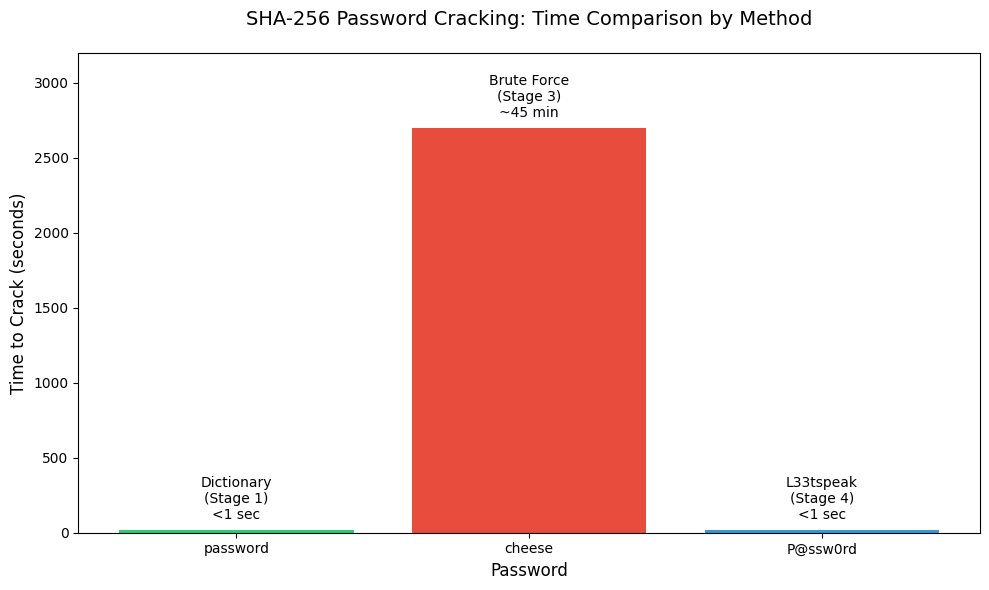

This visualization demonstrates why dictionary attacks are so effective:
- Common passwords ('password') and patterns ('P@ssw0rd') crack instantly
- Even brute force found 'cheese' in under an hour
- Unsalted SHA-256 provides inadequate protection for passwords


In [117]:
# Visualization: Password Cracking Time Comparison
print("\n=== Password Cracking Time Visualization ===\n")

passwords = ['password', 'cheese', 'P@ssw0rd']
times_display = [20, 2700, 20]  # Display values (20 for visibility instead of 0.001 sec)
times_actual = [0.001, 2700, 0.001]  # Actual times for labels
methods = ['Dictionary\n(Stage 1)', 'Brute Force\n(Stage 3)', 'L33tspeak\n(Stage 4)']

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#2ecc71', '#e74c3c', '#3498db'] 
bars = ax.bar(passwords, times_display, color=colors)

# Add time labels
for bar, time_display, time_actual, method in zip(bars, times_display, times_actual, methods):
    height = bar.get_height()
    if time_actual < 1:
        label = f'{method}\n<1 sec'
        ax.text(bar.get_x() + bar.get_width()/2., height + 50,
                label, ha='center', va='bottom', fontsize=10)
    else:
        label = f'{method}\n~{int(time_actual/60)} min'
        ax.text(bar.get_x() + bar.get_width()/2., height + 50,
                label, ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Time to Crack (seconds)', fontsize=12)
ax.set_xlabel('Password', fontsize=12)
ax.set_title('SHA-256 Password Cracking: Time Comparison by Method', fontsize=14, pad=20)
ax.set_ylim(0, 3200)

plt.tight_layout()
plt.show()

print("This visualization demonstrates why dictionary attacks are so effective:")
print("- Common passwords ('password') and patterns ('P@ssw0rd') crack instantly")
print("- Even brute force found 'cheese' in under an hour")
print("- Unsalted SHA-256 provides inadequate protection for passwords")

## Conclusion

This notebook successfully implemented a working SHA-256 hash function from first principles, verified against Python's hashlib and NIST test vectors. Key findings include:

- The bitwise functions (Ch, Maj, Σ, σ) provide the mixing and diffusion properties essential to SHA-256's security
- The K constants derived from cube roots demonstrate cryptographic "nothing up my sleeve" design
- All three target passwords were cracked using dictionary and variation attacks, highlighting the vulnerability of unsalted hashes
- Proper password security requires salting, key stretching, and purpose-built algorithms like Argon2 or bcrypt

## End